# 4장 모델 훈련

In [1]:
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# 4.1 선형 회귀

* 선형 모델은 입력 특성의 가중치 합과 편향을 더해 예측을 만든다.
* Ȳ = $Θ_j$ + $Θ_1x_1$ + ... + $Θ_n$$x_n$
* Ȳ = 예측값 / n = 특성의 수 / $x_i$ = i번째 특성값 / $Θ_j$ = j번째 모델 파라미터(편향과 특성 가중치)
* Ȳ = $h_Θ$(x) = Θㆍx
* Ȳ = 모델 파라미터를 사용한 가설함수 / x = 특성 벡터 / Θ = 특성 가중치를 담은 모델의 파라미터
* 평균 제곱근 오차(RMSE)를 최소화하는 Θ를 찾는 것이 목표

## 4.1.1 정규방정식

$\hat{\boldsymbol{\theta}} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$
* 비용 함수를 최소화하는 Θ값을 찾기 위한 해석적인 방법

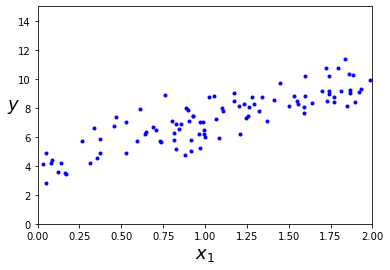

In [2]:
import numpy as np
import matplotlib.pyplot as plt

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

In [3]:
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.15485116],
       [2.91730264]])

In [4]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.15485116],
       [9.98945645]])

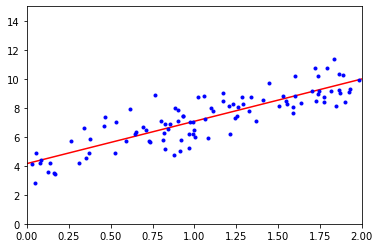

In [5]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

In [6]:
#선형 회귀
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.15485116]), array([[2.91730264]]))

In [7]:
#LinearRegression 클래스는 scipy.linalg.lstsq() 함수("least squares"의 약자)를 사용
theta_best_svd, residuals, rank, s =np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.15485116],
       [2.91730264]])

* 이 함수는 $\mathbf{X}^+\mathbf{y}$을 계산
* $\mathbf{X}^{+}$는 $\mathbf{X}$의 유사역행렬(pseudoinverse)
* np.linalg.pinv()을 사용해서 유사역행렬을 직접 계산할 수 있다.

In [8]:
np.linalg.pinv(X_b).dot(y)

array([[4.15485116],
       [2.91730264]])

# 4.2 경사 하강법

* 기본 아이디어는 비용 함수를 최소화하기 위해 반복해서 파라미터를 조정해가는 것
* 중요한 파라미터는 스텝의 크기로, 학습률 하이퍼파라미터로 결정
 - 학습률이 너무 작으면 알고리즘이 수렴하기 위해 반복을 많이 진행
 - 학습률이 너무 크면 골짜기를 가로질러 반대편으로 건너뛰게 됨
1. 임의의 파라미터 벡터 Θ에 대해 비용 함수의 현재 gradient를 계산
2. gradient가 감소하는 방향으로 진행
3. gradient가 0이 되면 최솟값에 도달!

* 경사 하강법의 문제점
 - Global Minimum 보다 덜 좋은 Local Minimum에 수렴
 - 반대쪽에서 시작하면 시간이 오래걸리고 일찍 멈추게 되어 최솟값에 도달하지 못한다.


## 4.2.1 배치 경사 하강법

* 편도함수(Partial Derivative) : 파라미터가 조금 변경될 때 비용 함수가 얼마나 바뀌는지 계산
* 식 4-6: 비용 함수의 그레이디언트 벡터
$
\dfrac{\partial}{\partial \boldsymbol{\theta}} \text{MSE}(\boldsymbol{\theta})
 = \dfrac{2}{m} \mathbf{X}^T (\mathbf{X} \boldsymbol{\theta} - \mathbf{y})
$
* 경사 하강법 스텝 : 전체 훈련 세트 X에 대해 계산
* 속도가 느리지만, 특성 수에 민감하지 않다.
* 식 4-7: 경사 하강법의 스텝
$
\boldsymbol{\theta}^{(\text{next step})} = \boldsymbol{\theta} - \eta \dfrac{\partial}{\partial \boldsymbol{\theta}} \text{MSE}(\boldsymbol{\theta})
$

In [9]:
eta = 0.1
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)

for iteration in range(n_iterations):
    gradients = 2 / m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
theta

array([[4.15485116],
       [2.91730264]])

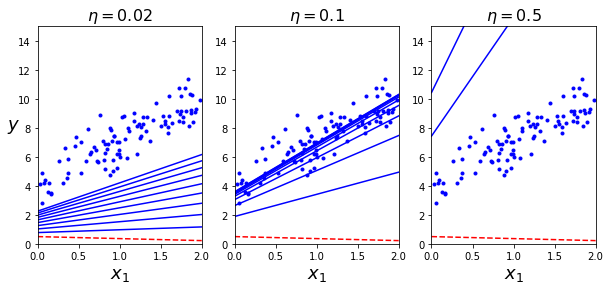

In [10]:
#여러가지 학습률에 대한 경사 하강법
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)
    
    
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()
#반복 횟수를 아주 크게 지정하고 gradient 벡터가 허용오차보다 작아지면 경사하강법 알고리즘을 중지


## 4.2.2 확률적 경사 하강법

* 매 스텝에서 한 개의 샘플을 무작위로 선택하고, 그 하나의 샘플에 대한 gradient를 계산
* 알고리즘 처리 속도가 훨씬 빠르고, 매 반복에서 하나의 샘플만 메모리에 있으면 되므로 매우 큰 훈련 세트에도 적용할 수 있다.
* 하지만 배치 경사 하강법보다 훨씬 불안정하고, 알고리즘이 멈출 때 최적치가 아닐 수 있다.
* 무작위성은 지역 최솟값에서 탈출시켜줘서 좋지만 알고리즘을 전역 최솟값에 다다르지 못하게 한다는 점이 좋지 않다.
* 담금질 기법(Simulated Annealing): 시작할 때는 학습률을 크게하고, 점차 작게 줄여서 알고리즘이 전역 최솟값에 도달하게 한다.
* 학습 스케쥴(Learning Schedule) : 매 반복에서 학습률을 결정하는 함수

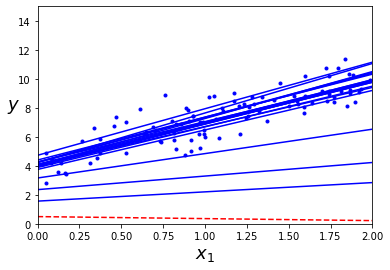

In [11]:
#학습 스케쥴을 사용한 확률적 경사 하강법
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

n_epochs = 50
t0, t1 =5, 50

def learning_schedule(t):
    return t0 / (t + t1)
theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    
            y_predict = X_new_b.dot(theta)           
            style = "b-" if i > 0 else "r--" 
            plt.plot(X_new, y_predict, style) 
        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index +1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
plt.plot(X, y, "b.")                            
plt.xlabel("$x_1$", fontsize=18)                    
plt.ylabel("$y$", rotation=0, fontsize=18)         
plt.axis([0, 2, 0, 15])                             
plt.show()                                   

In [12]:
#SGDRegressor을 이용한 선형회귀
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter = 1000, tol=1e-3, penalty=None, eta0= 0.1)
sgd_reg.fit(X, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([4.18924413]), array([2.95919796]))

## 미니배치 경사 하강법

* 미니배치라 부르는 임의의 작은 샘플 세트에 대해 gradient를 계산
* 헹렬 연산에 최적화된 하드웨어, GPU를 사용해서 얻는 성능 향상
* SGD보다 덜 불안정하겠지만, 지역 최솟값에서 빠져나오기는 더 힘들다.

In [13]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [14]:
theta

array([[4.22183924],
       [3.01011122]])

In [15]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

In [16]:
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

IndexError: too many indices for array

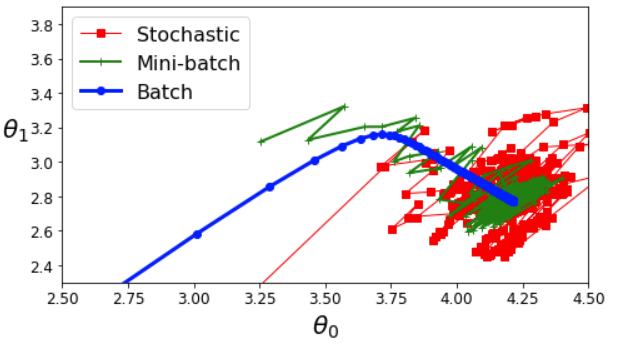

# 4.3 e다항 회귀

* 다항 회귀(Polynomial Regression) : 비선형 데이터를 학습하기 위해, 각 특성의 거듭제곱을 새로운 특성으로 추가하고, 이 확정된 특성을 포함한 데이터셋에 선형 모델을 훈련시키는 것

In [18]:
#2차 비선형 데이터
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

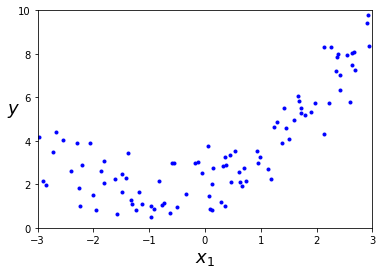

In [19]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [20]:
#사이킷런의 PolynomialFeatures() : 훈련 세트에 있는 각 특성을 제곱하여 새로운 특성으로 추가
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([2.38942838]), array([2.38942838, 5.709368  ]))

In [21]:
#확장된 훈련 데이터에 LinearRegression을 적용
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.9735233]), array([[0.95038538, 0.52577032]]))

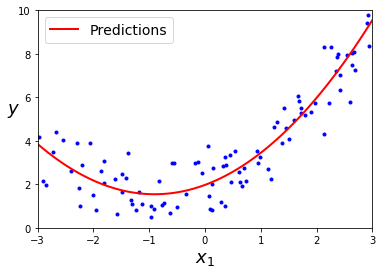

In [22]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

* 특성이 여러 개일 때 다항 회귀는 이 특성 사이의 관계를 찾을 수 있다.
* PolynomialFeatures가 주어진 차수까지 특성 간의 모든 교차항을 추가하기 때문
* 예를 들어 a, b 뿐만 아니라 $a^2$, $a^3$, $a^2b$도 특성으로 추가한다.

# 4.4 학습 곡선

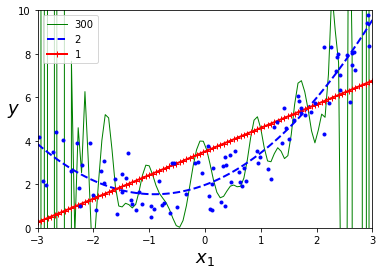

In [26]:
#300차 다항 회귀
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

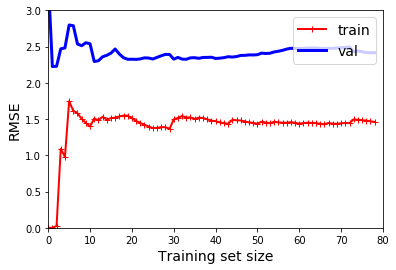

In [27]:
#모델의 일반화 성능을 추정하기 위해 학습 곡선을 살펴보기도 한다.
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)             
    
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                      
plt.show()
#과소적합 모델의 전형적인 모습

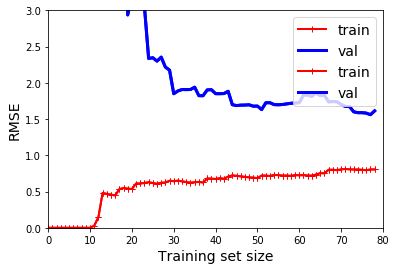

In [30]:
#10차 다항 회귀
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)
plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])          
plt.show()                    

### 평향/ 분산 트레이드 오프
* 편향 : 일반화 오차중에서 편향은 잘못된 가정으로 인한 것, 평향이 큰 모델은 훈련 데이터에 과소적합되기 쉽다.
* 분산 : 훈련 데이터에 있는 작은 변동에 모델이 과도하게 민감하기 때문. 자유도가 높은 모델이 높은 분산을 가지기 쉬워 훈련 데이터에 과대적합 되는 경향
* 줄일 수 없는 오차 : 데이터 자체에 있는 잡음 떄문에 발생. 이 오차를 줄이기위해서는 잡음을 제거해야함

# 4.5 규제가 있는 선형 모델

* 과대적합을 감소시키기위해 모델을 제한한다.
* 다항 회귀 모델에서 규제하는 간단한 방법은 다항식의 차수를 감소시키는 것
* 선형 회귀 모델에서는 보통 모델의 가중치를 제한함으로써 규제를 가한다.

## 4.5.1 릿지 회귀

* $ J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + \alpha \dfrac{1}{2}\sum\limits_{i=1}^{n}{\theta_i}^2 $
* 규제가 추가된 선형 회귀 버전(규제항이 비용함수에 추가)
* 학습 알고리즘을 데이터에 맞추는 것뿐만 아니라 모델의 가중치가 가능한 한 작게 유지되도록 노력
* 규제항은 훈련하는 동안에만 비용함수에 추가
* a = 규제 정도

In [42]:
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [43]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
print("RedgeRegressor : ", ridge_reg.predict([[1.5]]))

sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
print("sgdRegressor : ", sgd_reg.predict([[1.5]]))

RedgeRegressor :  [[1.61270538]]
sgdRegressor :  [1.52970441]


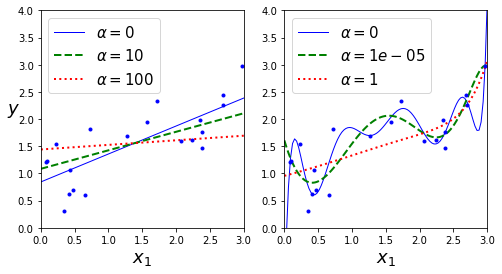

In [44]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()
# 규제가 증가할 수록, 모델의 분산은 줄지만, 편향은 커지게 된다.

## 4.5.2 라쏘 회귀

* $ J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right| $
* 릿지 회귀처럼 비용 험수에 규제항을 더하지만, 노름의 제곱을 2로 나눈 것 대신 가중치 벡터의 노름을 사용한다.
* 덜 중요한 특성의 가중치를 제거하려고 한다.
* 자동으로 특성 선택을 하고 희소(Sparse model)을 만든다.

C:\Users\uoo13\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.273905140988263, tolerance: 0.000890532299396773
  positive)


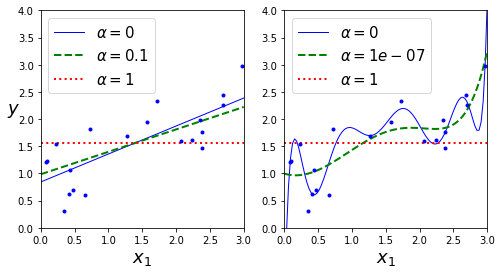

In [45]:
#라쏘 모델 적용
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

plt.show()

In [47]:
#Lasso클래스를 사용한 간단한 사이킷런 예제
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.60412919])

## 4.5.3 엘라스틱넷

* $ J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + r \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right| + \dfrac{1 - r}{2} \alpha \sum\limits_{i=1}^{n}{{\theta_i}^2} $
* 릿지와 라쏘 회귀를 절충한 모델
* 규제항으로 릿지와 회귀의 규제항을 단순히 더해서 사용하며, 혼합 비율 r을 사용해 조절
* r= 0 릿지회귀 / r = 1 라쏘 회귀
* 특성 수가 훈련 샘플 수보다 많거나 특성 몇개가 강하게 연관되어 있을 때는 보통 라쏘가 문제를 일으키므로 엘라스틱 넷을 선호

In [52]:
#사이킷런의 ElasticNet
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.60730369])

## 4.5.4 조기 종료

* 조기종료(Early Stopping) : 검증 에러가 최솟값에 도달하면 바로 훈련을 중지시키는 것

In [54]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(),
                                                  test_size=0.5, random_state=10)

In [57]:
from sklearn.base import clone

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005)
minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)


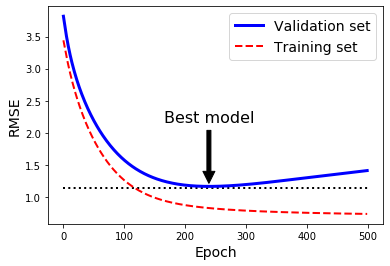

In [60]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,                      
    penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

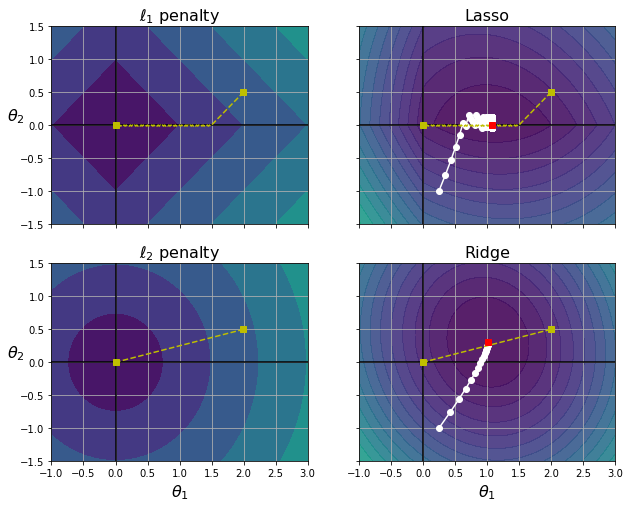

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 2., 0, "Lasso"), (1, N2, 0,  2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    ax = axes[i, 0]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, N / 2., levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)

    ax = axes[i, 1]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)

plt.show()

# 4.6 로지스틱 회귀
* 로지스틱 회귀(Logistic Regression) : 샘플이 특정 클래스에 속할 확률을 추정하는데 사용

## 4.6.1 확률 추정

* 입력 특성의 가중치 합을 계산
* 대신 선형 회귀처럼 바로 결과를 출력하지 않고, 결과값의 로지스틱을 출력한다.
* 로지스틱 : 0과 1사이의 값을 출력하는 시그모이드 함수(Sigmoid Function)
* 로지스틱 함수 𝜎(t) = 1 / (1 + exp(-t))

## 4.6.2 훈련과 비용 함수

* 훈련의 목적은 양성 샘플에 대해서는 높은 확률을 추정하고, 음성 샘플에 대해서는 낮은 확률을 추정하는 모델의 파라미터 벡터를 찾는 것

* $
c(\boldsymbol{\theta}) =
\begin{cases}
  -\log(\hat{p}) &amp; \text{if } y = 1, \\
  -\log(1 - \hat{p}) &amp; \text{if } y = 0.
\end{cases}
$
* 식 4-17: 로지스틱 회귀 비용 함수(로그 손실)

$ J(\boldsymbol{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]} $
* 식 4-18: 로지스틱 비용 함수의 편도 함수

$ \dfrac{\partial}{\partial \theta_j} \text{J}(\boldsymbol{\theta}) = \dfrac{1}{m}\sum\limits_{i=1}^{m}\left(\mathbf{\sigma(\boldsymbol{\theta}}^T \mathbf{x}^{(i)}) - y^{(i)}\right)\, x_j^{(i)} $

## 4.6.3 결정 경계

In [64]:
#붓꽃 데이터셋 사용
from sklearn import datasets
iris = datasets.load_iris()
print(list(iris.keys()))
X = iris["data"][:, 3:]
y = (iris["target"] == 2).astype(np.int)

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']


In [65]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

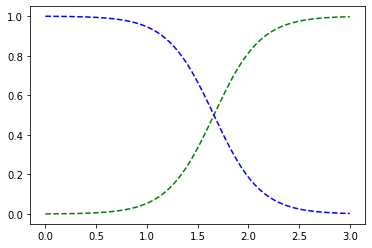

In [69]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g--", label="Irisi virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris virginica")

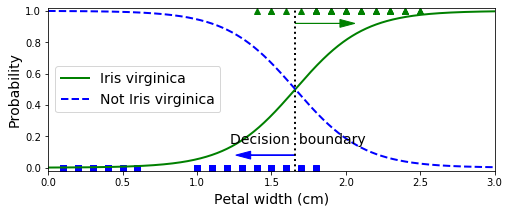

In [70]:
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])

plt.show()

* 양쪽의 클래스 결정 확률이 똑같이 50%가 되는 근방에서 결정 경계(Decision Boundary)가 만들어진다.

In [71]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

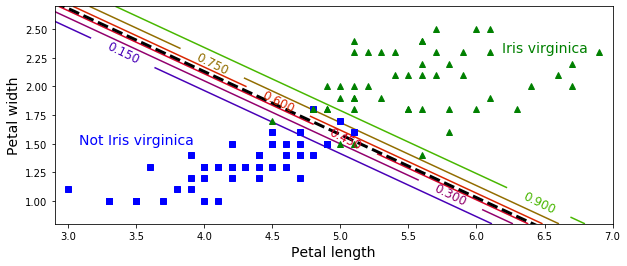

In [72]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])

plt.show()

## 4.6.4 소프트맥스 회귀
* 로지스틱 회귀 모델은 여러 개의 이진 분류기를 훈련시켜 연결하지 않고 직접 다중 클래스를 지원하도록 일반화될 수 있다. 이를 소프트맥스 회귀(Softmax Regression) / 다항 로지스틱 회귀(Multinomial Logistic Regression)라고 한다.
* 샘플 x가 주어지면 먼저 소프트맥스 회귀 모델이 각 클래스 k에 대한 점수 $s_k$(x)를 계산하고, 그 점수에 소프트맥스 함수를 적용하여 각 클래스의 확률을 추정한다.
* 식 4-20: 소프트맥스 함수

$ \hat{p}_k = \sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}} $

* 모델이 타킷 클래스에 대해서는 높은 확률을 추정하도록 만드는 것이 목적
* 크로스 엔트로피(Cross Entropy) 비용함수를 최소화하는 것은 타깃 클래스에 대해 낮은 확률을 예측하는 모델을 억제하므로 이 목적에 부합
* 식 4-22: 크로스 엔트로피 비용 함수

$ J(\boldsymbol{\Theta}) = - \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)} $
* 식 4-23: 클래스 k에 대한 크로스 엔트로피의 그레이디언트 벡터

$ \nabla_{\boldsymbol{\theta}^{(k)}} \, J(\boldsymbol{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}} $

In [74]:
#소프트맥스 회귀를 사용한 붓꽃 분류
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

#매개변수 multinomial, lbfgs 같이  소프트맥스 회귀를 지원하는 알고리즘 사용
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [75]:
print(softmax_reg.predict([[5, 2]]))
print(softmax_reg.predict_proba([[5, 2]]))

[2]
[[6.38014896e-07 5.74929995e-02 9.42506362e-01]]


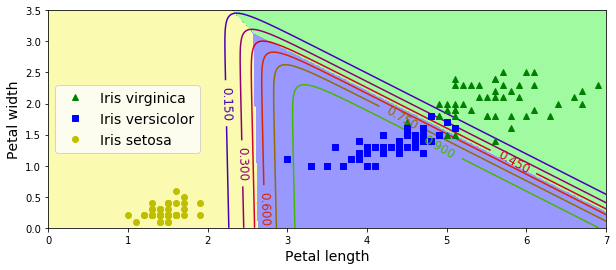

In [76]:
#결정경계
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])

plt.show()